# 1D harmonic oscillator physics-informed neural network (PINN)

This notebook contains the code to reproduce the plots presented in my blog post ["So, what is a physics-informed neural network?"](https://benmoseley.blog/my-research/so-what-is-a-physics-informed-neural-network/). 

Please read the post for more details!

## Problem overview

The example problem we solve here is the 1D damped harmonic oscillator:
$$
m \dfrac{d^2 x}{d t^2} + \mu \dfrac{d x}{d t} + kx = 0~,
$$
with the initial conditions
$$
x(0) = 1~~,~~\dfrac{d x}{d t} = 0~.
$$
We will focus on solving the problem for the under-damped state, i.e. when 
$$
\delta < \omega_0~,~~~~~\mathrm{with}~~\delta = \dfrac{\mu}{2m}~,~\omega_0 = \sqrt{\dfrac{k}{m}}~.
$$
This has the following exact solution:
$$
x(t) = e^{-\delta t}(2 A \cos(\phi + \omega t))~,~~~~~\mathrm{with}~~\omega=\sqrt{\omega_0^2 - \delta^2}~.
$$

This problem was inspired by the following blog post: https://beltoforion.de/en/harmonic_oscillator/.

## Workflow overview

>First we will train a standard neural network to interpolate a small part of the solution, using some observed training points from the solution.

>Next, we will train a PINN to extrapolate the full solution outside of these training points by penalising the underlying differential equation in its loss function.

In [23]:
from PIL import Image
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize


In [24]:

# Define transversal Classes and Methods


def save_gif_PIL(outfile, files, fps=5, loop=0):
    "Helper function for saving GIFs"
    imgs = [Image.open(file) for file in files]
    imgs[0].save(fp=outfile, format='GIF', append_images=imgs[1:],
                 save_all=True, duration=int(1000/fps), loop=loop)

# Analitic solution for Oscillator

from IPython.display import clear_output


def plot_result(i, x, y, x_data, y_data, yh, xp=None):
    "Pretty plot training results"
    plt.figure(figsize=(8, 4))
    plt.plot(x, y, color="grey", linewidth=2,
             alpha=0.8, label="Exact solution")
    plt.plot(x, yh, color="tab:blue", linewidth=4,
             alpha=0.8, label="Neural network prediction")
    plt.scatter(x_data, y_data, s=60, color="tab:orange",
                alpha=0.4, label='Training data')
    if xp is not None:
        plt.scatter(xp, -0*np.ones_like(xp), s=60, color="tab:green", alpha=0.4,
                    label='Physics loss training locations')
    l = plt.legend(loc=(1.01, 0.34), frameon=False, fontsize="large")
    plt.setp(l.get_texts(), color="k")
    plt.xlim(-0.05, 1.05)
    plt.ylim(-1.1, 1.1)
    plt.text(1.065, 0.7, "Training step: %i" %
             (i), fontsize="xx-large", color="k")
    plt.axis("off")
    
def oscillator(d, w0, x):
    """Defines the analytical solution to the 1D underdamped harmonic oscillator problem. 
    Equations taken from: https://beltoforion.de/en/harmonic_oscillator/"""
    assert d < w0
    w = np.sqrt(w0**2-d**2)
    phi = np.arctan(-d/w)
    A = 1/(2*np.cos(phi))
    cos = np.cos(phi+w*x)
    sin = np.sin(phi+w*x)
    exp = np.exp(-d*x)
    y = exp*2*A*cos
    return y


# Quantum model based in VQC(Variational Quantum Circuit)
dev = qml.device("default.qubit", wires=2)


@qml.qnode(dev)
def model(x, w):
    # circuit  1
    # qml.RY(x*w[2], wires=0)
    # qml.RX(x*w[3], wires=1)
    # qml.RY(w[4], wires = 0)
    # qml.RY(w[5], wires = 1)
    # qml.CNOT(wires = [1,0])

    # circuit 2
    # qml.RY(x*w[2], wires=0)
    # qml.RX(w[0], wires=0)
    # qml.RY(w[1], wires=0)

   # circuit 3
    # qml.Hadamard(wires=0)
    # qml.Hadamard(wires = 1)
    qml.RY(x*w[0], wires=0)
    qml.RY(x*w[1], wires=1)
    qml.CNOT(wires=[1, 0])

    qml.RX(w[2], wires=0)
    qml.RY(w[3], wires=0)
    qml.CNOT(wires=[1, 0])

    qml.RX(w[4], wires=0)
    qml.RY(w[5], wires=0)
    qml.CNOT(wires=[1, 0])

    qml.RX(w[6], wires=0)
    qml.RY(w[7], wires=0)
    qml.CNOT(wires=[1, 0])


    qml.RX(w[8], wires=0)
    qml.RY(w[9], wires=1)
    qml.CNOT(wires=[1, 0])
    return qml.expval(qml.PauliZ(wires=0))


In [25]:
d, w0 = 2, 20

# Get the analytical solution over the full domain
x = np.linspace(0, 1, 500)
y = oscillator(d, w0, x)
print(x.shape, y.shape)

# slice out a small number of points from the LHS of the domain
x_data = x[0:200:20]
y_data = y[0:200:20]
data = list(zip(x_data, y_data))
print(data)
print(x_data.shape, y_data.shape)

plt.figure()
plt.plot(x, y, label="Exact solution")
plt.scatter(x_data, y_data, color="tab:orange", label="Training data")
plt.legend()
plt.show()


(500,) (500,)
[(tensor(0., requires_grad=True), tensor(1., requires_grad=True)), (tensor(0.04008016, requires_grad=True), tensor(0.71102225, requires_grad=True)), (tensor(0.08016032, requires_grad=True), tensor(0.06482942, requires_grad=True)), (tensor(0.12024048, requires_grad=True), tensor(-0.52211629, requires_grad=True)), (tensor(0.16032064, requires_grad=True), tensor(-0.72837541, requires_grad=True)), (tensor(0.2004008, requires_grad=True), tensor(-0.49429743, requires_grad=True)), (tensor(0.24048096, requires_grad=True), tensor(-0.01680151, requires_grad=True)), (tensor(0.28056112, requires_grad=True), tensor(0.39941576, requires_grad=True)), (tensor(0.32064128, requires_grad=True), tensor(0.52926768, requires_grad=True)), (tensor(0.36072144, requires_grad=True), tensor(0.34211867, requires_grad=True))]
(10,) (10,)


## Normal Quantum Neural Network


Optimization terminated successfully.
         Current function value: 0.000860
         Iterations: 27
         Function evaluations: 30
         Gradient evaluations: 30
         Hessian evaluations: 27
[ 1.20430584e+01 -1.24774612e+01  4.91375371e+00 -1.91852285e+00
 -5.53382000e+00  1.45937267e+00  2.20549499e-04  1.96299748e+00
 -4.08110590e+00  6.17336406e+00]
Solution: f([ 1.20430584e+01 -1.24774612e+01  4.91375371e+00 -1.91852285e+00
 -5.53382000e+00  1.45937267e+00  2.20549499e-04  1.96299748e+00
 -4.08110590e+00  6.17336406e+00]) = 0.00086


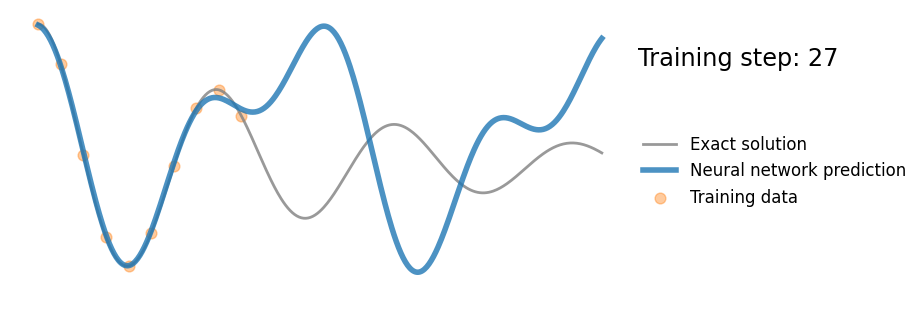

In [30]:
def average_loss(w):
    losses = 0
    losses_ic = 0
    i = 0
    for x, y in data:
        losses += (model(x, w) - y) ** 2
        # print(qml.draw(model)(x,w))
        if  i ==0 :
            losses_ic= (model(x,w)-y)**2
        i += 1
    return losses/len(data) + losses_ic


gradient_fn_w = qml.grad(average_loss, argnum=0)
hessian_fn_w = qml.jacobian(gradient_fn_w, argnum=0)


# w = np.array([-1., -0.2, 0.,0.5, -1, -0.2], requires_grad = True)
# w = np.array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5], requires_grad = True)
w = 4*np.pi*np.random.rand(10) - 2*np.pi

lr = 1.5
number_epoch = 2000
# optimizacion por método de descenso de gradiente
# for epoch in range(number_epoch):
#    yh =  model(x,w)
#    w = w - lr*gradient_fn_w(w)
#    if (epoch + 1) % 100 == 0:
#        print("epoch", epoch + 1, "loss", average_loss(w))
#        plot_result(epoch+1, x, y, x_data,y_data, yh)
#        clear_output(wait=True)

# Optimización por método de cuasi Newton BFGS


def print_log(w):
    global iteration
    global fout
    fout.write('At iterate {iteration:4d},  loss={loss: 3.12f}, weights ={weights} \n'.format(
        iteration=iteration, loss=average_loss(w), weights=w))
    # print('At iterate {iteration:4d},  loss={loss: 3.12f}, weights ={weights} \n'.format(iteration = iteration, loss = average_loss(w),weights = w ))
    iteration += 1


iteration = 1

fout = open('../../media/logs/CG_steps_QNN.txt', 'w')
optimize_losses = optimize.minimize(average_loss, w, method='Newton-CG',
                                    jac=gradient_fn_w, hess=hessian_fn_w, callback=print_log, options={'disp': True})

fout.close()

# evaluate solution
print(optimize_losses['x'])
# evaluate solution
solution = optimize_losses['x']
evaluation = average_loss(solution)
print('Solution: f(%s) = %.5f' % (solution, evaluation))
yh = model(x, solution)
plot_result(optimize_losses['nit'], x, y, x_data, y_data, yh)


Optimization terminated successfully.
         Current function value: 0.000860
         Iterations: 123
         Function evaluations: 132
         Gradient evaluations: 132
[ 1.20430492e+01  1.24774662e+01 -3.14170313e+00  5.58542130e+00
  4.46912129e+00 -4.39111904e+00  4.94040913e+00 -5.36307434e-05
  5.38887361e+00 -6.17336524e+00]
Solution: f([ 1.20430492e+01  1.24774662e+01 -3.14170313e+00  5.58542130e+00
  4.46912129e+00 -4.39111904e+00  4.94040913e+00 -5.36307434e-05
  5.38887361e+00 -6.17336524e+00]) = 0.00086


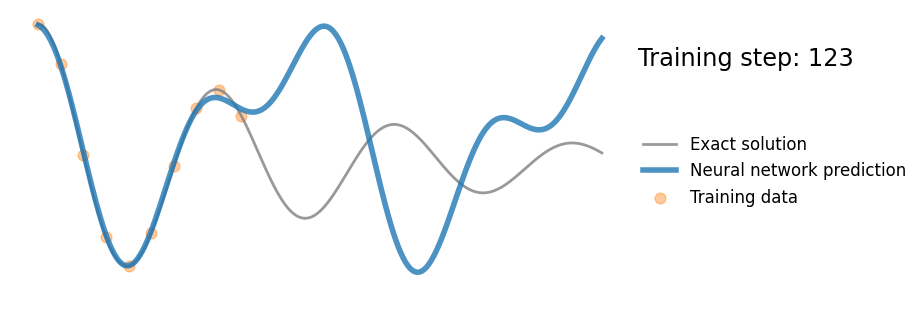

In [27]:
iteration = 1

fout = open('../../media/logs/BFGS_steps_QNN.txt', 'w')
optimize_losses = optimize.minimize(
    average_loss, w, method='BFGS', jac=gradient_fn_w, callback=print_log, options={'disp': True})
fout.close()

# evaluate solution
print(optimize_losses['x'])
# evaluate solution
solution = optimize_losses['x']
evaluation = average_loss(solution)
print('Solution: f(%s) = %.5f' % (solution, evaluation))
yh = model(x, solution)
plot_result(optimize_losses['nit'], x, y, x_data, y_data, yh)


## Physics Informed Quantum Neural Network


In [31]:
from IPython.display import clear_output
# sample locations over the problem domain
x_physics = np.linspace(0, 1, 30, requires_grad=True)
# x_physics = np.array([-2., -0.2, 0.,0.5, -1, -0.2], requires_grad = True)
mu, k = 2*d, w0**2


def average_loss(w):
    losses = 0
    losses2 = 0
    losses_ic = 0
    dx = qml.grad(model, argnum=0)  # computes dy/dx
    dx2 = qml.grad(dx,  argnum=0)  # computes d^2y/dx^2
    i=0
    for x, y in data:
        losses += (model(x, w) - y) ** 2
        # print(qml.draw(model)(x,w))
        if  i ==0 :
            losses_ic= (model(x,w)-y)**2
        i += 1
    
    for x_phy in x_physics:
        yhp = model(x_phy, w)
        # computes the residual of the 1D harmonic oscillator differential equation
        physics = dx2(x_phy, w) + mu*dx(x_phy, w) + k*yhp
        # loss2 = (1e-4)*torch.mean(physics**2)
        losses2 += physics**2
    return losses/len(data) + losses_ic + 1e-4*losses2/len(x_physics)


gradient_fn_w = qml.grad(average_loss, argnum=0)
hessian_fn_w = qml.jacobian(gradient_fn_w, argnum=0)

# w = np.array([-1., -0.2, 0.,0.5, -1, -0.2], requires_grad = True)
# w = np.array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5], requires_grad = True)
# w = np.array([0.0, -0.0, 0.0,0.0, 0.0, 0.0], requires_grad = True)
# w = [-31.32352916, 6.97765977, -19.75120469, 0.71892541,  -1., -0.2]
w = [ 2.68042215,  2.92433481,  0.02854919,  1.0318043,  -2.71993564, -1.19001216, 1.87635628,  2.85404538,  3.09725585, -2.47637846] # --> Converge bien Newton CG
#w = 2*np.pi*np.random.rand(10) - np.pi

# lr = 1.5
lr = 2
# Con lr =1e-3 y 1000 epocas se demora 40 minutos
# Optimización por método de cuasi Newton BFGS


def print_log(w):
    global iteration
    global fout
    fout.write('At iterate {iteration:4d},  loss={loss: 3.6f}, weights ={weights} \n'.format(
        iteration=iteration, loss=average_loss(w), weights=w))
    # print('At iterate {iteration:4d},  loss={loss: 3.6f}, weights ={weights} \n'.format(iteration = iteration, loss = average_loss(w),weights = w ))
    iteration += 1


iteration = 1
fout = open('../../media/logs/CG_steps_QPINN.txt', 'w')
optimize_losses = optimize.minimize(average_loss, w, method='Newton-CG',
                                    jac=gradient_fn_w, hess=hessian_fn_w, callback=print_log, options={'disp': True})
fout.close()

# evaluate solution
print(optimize_losses['x'])
# evaluate solution
solution = optimize_losses['x']
evaluation = average_loss(solution)
print('Solution: f(%s) = %.5f' % (solution, evaluation))
yh = model(x, solution)
plot_result(optimize_losses['nit'], x, y, x_data, y_data, yh)


KeyboardInterrupt: 

In [32]:
w = [ 2.68042215,  2.92433481,  0.02854919,  1.0318043,  -2.71993564, -1.19001216, 1.87635628,  2.85404538,  3.09725585, -2.47637846] # --> Converge bien Newton CG

iteration = 1
fout = open('../../media/logs/BFGS_steps_QPINN.txt', 'w')

optimize_losses = optimize.minimize(average_loss, w, method='BFGS', jac=gradient_fn_w, callback=print_log, options={'disp': True})
fout.close()


# evaluate solution
print(optimize_losses['x'])
# evaluate solution
solution = optimize_losses['x']
evaluation = average_loss(solution)
print('Solution: f(%s) = %.5f' % (solution, evaluation))
yh = model(x, solution)
plot_result(optimize_losses['nit'], x, y, x_data, y_data, yh)


Optimization terminated successfully.
         Current function value: 0.020697
         Iterations: 247
         Function evaluations: 283
         Gradient evaluations: 283
[19.50766387  2.87363235  1.28568421 -4.47781954 -5.15714288 -2.14644467
  1.26514719  4.6586626   2.17452399 -2.76653315]
Solution: f([19.50766387  2.87363235  1.28568421 -4.47781954 -5.15714288 -2.14644467
  1.26514719  4.6586626   2.17452399 -2.76653315]) = 0.02070
